In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import train_test_split

In [2]:
df_aaindex = pd.read_csv('../data/aaindex/df_aaindex19.csv')
print(df_aaindex.shape)
df_aaindex.head(1)
tmp = df_aaindex.drop('Unnamed: 0',axis=1).T
aa2val = dict()
for aa, val in zip(tmp.index, tmp.values):
    aa2val[aa]=val

(19, 21)


In [3]:
df_detect_peptide_train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')
train, val = train_test_split(df_detect_peptide_train, test_size=0.2, random_state=7)

In [4]:
def get_data_labelEnc(df):
    label_enc = {v:k+1 for k, v in enumerate('ARNDCQEGHILKMFPSTWYV')}
    label_enc['Z']=0
    aa_data = [np.array([seq.count(a) for a in 'ARNDCQEGHILKMFPSTWYV'] + list(np.array([aa2val[aa] for aa in seq]).sum(axis=0)))
               for seq in df.PEP.values]
    pep_data = [[label_enc[aa] for aa in seq] + [0]*(30-len(seq))
               for seq in df.PEP.values]
    en_data = [[label_enc[aa] for aa in seq]
               for seq in df.En.values]
    ec_data = [[label_enc[aa] for aa in seq]
               for seq in df.Ec.values]
    e1_data = [[label_enc[aa] for aa in seq]
               if seq != '-' else [0 for _ in range(31)]
               for seq in df.E1.values]
    e2_data = [[label_enc[aa] for aa in seq]
               if seq != '-' else [0 for _ in range(31)]
               for seq in df.E2.values]
    return np.array(aa_data), np.array(pep_data), np.array(en_data), np.array(ec_data), np.array(e1_data), np.array(e2_data), np.array(df.ID.values)

In [5]:
label_enc = {v:k+1 for k, v in enumerate('ARNDCQEGHILKMFPSTWYV')}
print(label_enc)

{'A': 1, 'R': 2, 'N': 3, 'D': 4, 'C': 5, 'Q': 6, 'E': 7, 'G': 8, 'H': 9, 'I': 10, 'L': 11, 'K': 12, 'M': 13, 'F': 14, 'P': 15, 'S': 16, 'T': 17, 'W': 18, 'Y': 19, 'V': 20}


In [6]:
aa_train, pep_train, en_train, ec_train, e1_train, e2_train, y_train = get_data_labelEnc(train)
aa_val, pep_val, en_val, ec_val, e1_val, e2_val, y_val = get_data_labelEnc(val)
aa_test, pep_test, en_test, ec_test, e1_test, e2_test, y_test = get_data_labelEnc(test)
print(aa_train.shape, pep_train.shape, en_train.shape, ec_train.shape, e1_train.shape, e2_train.shape, y_train.shape)
print(aa_val.shape, pep_val.shape, en_val.shape, ec_val.shape, e1_val.shape, e2_val.shape, y_val.shape)
print(aa_test.shape, pep_test.shape, en_test.shape, ec_test.shape, e1_test.shape, e2_test.shape, y_test.shape)

(543784, 39) (543784, 30) (543784, 31) (543784, 31) (543784, 31) (543784, 31) (543784,)
(135946, 39) (135946, 30) (135946, 31) (135946, 31) (135946, 31) (135946, 31) (135946,)
(134200, 39) (134200, 30) (134200, 31) (134200, 31) (134200, 31) (134200, 31) (134200,)


# Train

In [7]:
from tensorflow.python.client import device_lib

import tensorflow as tf
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        tf.config.experimental.set_virtual_device_configuration(gpus[0],
        [tf.config.experimental.VirtualDeviceConfiguration(memory_limit=1024*4)])
    except RuntimeError as e:
        print(e)

In [8]:
def plot_graphs(history, metric):
    plt.plot(history.history[metric])
    plt.plot(history.history['val_'+metric], '')
    plt.xlabel("Epochs")
    plt.ylabel(metric)
    plt.legend([metric, 'val_'+metric])

# high param

In [9]:
from tensorflow import keras

In [10]:
# Embedding
pep = tf.keras.layers.Input(shape=((30,)))
pep_embed = tf.keras.layers.Embedding(21, 32, input_length=30, mask_zero=True)(pep)
pep_embed = tf.keras.layers.Dropout(np.random.uniform(0, 0.2))(pep_embed)

meta = tf.keras.layers.Input(shape=((39,)))  # peptide info

# n = tf.keras.layers.Input(shape=((31,)))
# n_embed = tf.keras.layers.Embedding(21, 16, input_length=31, mask_zero=True)(n)
# n_embed = tf.keras.layers.Dropout(np.random.uniform(0, 0.2))(n_embed)

# c = tf.keras.layers.Input(shape=((31,)))
# c_embed = tf.keras.layers.Embedding(21, 16, input_length=31, mask_zero=True)(c)
# c_embed = tf.keras.layers.Dropout(np.random.uniform(0, 0.2))(c_embed)

# m1 = tf.keras.layers.Input(shape=((31,)))
# m1_embed = tf.keras.layers.Embedding(21, 16, input_length=31, mask_zero=True)(m1)
# m1_embed = tf.keras.layers.Dropout(np.random.uniform(0, 0.2))(m1_embed)

# m2 = tf.keras.layers.Input(shape=((31,)))
# m2_embed = tf.keras.layers.Embedding(21, 16, input_length=31, mask_zero=True)(m2)
# m2_embed = tf.keras.layers.Dropout(np.random.uniform(0, 0.2))(m2_embed)


# LSTM
net_meta = tf.keras.layers.Dense(32, activation='relu')(meta)
net_meta = tf.keras.layers.Dropout(np.random.uniform(0, 0.2))(net_meta)

# n_lstm = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(8))(n_embed)
# n_lstm = tf.keras.layers.Dense(8, activation='relu')(n_lstm)
# n_lstm = tf.keras.layers.Dropout(np.random.uniform(0, 0.2))(n_lstm)

# c_lstm = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(8))(c_embed)
# c_lstm = tf.keras.layers.Dense(8, activation='relu')(c_lstm)
# c_lstm = tf.keras.layers.Dropout(np.random.uniform(0, 0.2))(c_lstm)

# m1_lstm = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(8))(m1_embed)
# m1_lstm = tf.keras.layers.Dense(8, activation='relu')(m1_lstm)
# m1_lstm = tf.keras.layers.Dropout(np.random.uniform(0, 0.2))(m1_lstm)

# m2_lstm = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(8))(m2_embed)
# m2_lstm = tf.keras.layers.Dense(8, activation='relu')(m2_lstm)
# m2_lstm = tf.keras.layers.Dropout(np.random.uniform(0, 0.2))(m2_lstm)

pep_lstm = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(16))(pep_embed)
pep_lstm = tf.keras.layers.Dense(16, activation='relu')(pep_lstm)
pep_lstm = tf.keras.layers.Dropout(np.random.uniform(0, 0.2))(pep_lstm)


# Dense
merge = tf.keras.layers.concatenate([pep_lstm, 
                                     net_meta,
#                                      n_lstm,
#                                      c_lstm,
#                                      m1_lstm,
#                                      m2_lstm
                                    ])
net_merge = tf.keras.layers.Dense(64, activation='relu')(merge)
net_merge = tf.keras.layers.Dropout(np.random.uniform(0, 0.2))(net_merge)
net_merge = tf.keras.layers.Dense(32, activation='relu')(net_merge)
net_merge = tf.keras.layers.Dropout(np.random.uniform(0, 0.2))(net_merge)

output = tf.keras.layers.Dense(1, activation = 'sigmoid')(net_merge)

model_high = tf.keras.Model(inputs=[pep, meta,
#                                     n, c, m1, m2
                                   ],
                            outputs=[output])

model_high.summary()

model_high.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              optimizer=tf.keras.optimizers.Adam(5e-4),
              metrics=['accuracy'])

es = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                      mode='min', 
                                      verbose=1,
                                      patience=50)

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 30)]         0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 30, 32)       672         input_1[0][0]                    
__________________________________________________________________________________________________
dropout (Dropout)               (None, 30, 32)       0           embedding[0][0]                  
__________________________________________________________________________________________________
bidirectional (Bidirectional)   (None, 32)           6272        dropout[0][0]                    
______________________________________________________________________________________________

In [ ]:
history = model_high.fit([pep_train, aa_train, 
#                           en_train, ec_train, e1_train, e2_train
                         ],
                    y_train, 
                    epochs=300,
                    batch_size=128,
                    validation_data=([pep_val, aa_val, 
#                                       en_val, ec_val, e1_val, e2_val
                                     ], y_val),
                    callbacks=[es]
                        )

Epoch 1/300
4249/4249 [==============================] - 108s 23ms/step - loss: 3.6360 - accuracy: 0.5242 - val_loss: 0.5144 - val_accuracy: 0.7623
Epoch 2/300
4249/4249 [==============================] - 126s 30ms/step - loss: 0.5168 - accuracy: 0.7575 - val_loss: 0.4508 - val_accuracy: 0.7894
Epoch 3/300
4249/4249 [==============================] - 189s 45ms/step - loss: 0.4578 - accuracy: 0.7889 - val_loss: 0.4307 - val_accuracy: 0.8018
Epoch 4/300
4249/4249 [==============================] - 219s 52ms/step - loss: 0.4415 - accuracy: 0.7981 - val_loss: 0.4284 - val_accuracy: 0.8045
Epoch 5/300
4249/4249 [==============================] - 220s 52ms/step - loss: 0.4347 - accuracy: 0.8016 - val_loss: 0.4215 - val_accuracy: 0.8075
Epoch 6/300
4249/4249 [==============================] - 272s 64ms/step - loss: 0.4283 - accuracy: 0.8053 - val_loss: 0.4205 - val_accuracy: 0.8065
Epoch 7/300
4249/4249 [==============================] - 314s 74ms/step - loss: 0.4246 - accuracy: 0.8075 - val_

4249/4249 [==============================] - 282s 66ms/step - loss: 0.3943 - accuracy: 0.8220 - val_loss: 0.3978 - val_accuracy: 0.8215
Epoch 57/300
4249/4249 [==============================] - 292s 69ms/step - loss: 0.3964 - accuracy: 0.8204 - val_loss: 0.3982 - val_accuracy: 0.8214
Epoch 58/300
4249/4249 [==============================] - 316s 74ms/step - loss: 0.3951 - accuracy: 0.8218 - val_loss: 0.3973 - val_accuracy: 0.8221
Epoch 59/300
4249/4249 [==============================] - 315s 74ms/step - loss: 0.3941 - accuracy: 0.8221 - val_loss: 0.3975 - val_accuracy: 0.8216
Epoch 60/300
4249/4249 [==============================] - 321s 76ms/step - loss: 0.3933 - accuracy: 0.8217 - val_loss: 0.3993 - val_accuracy: 0.8217
Epoch 61/300
4249/4249 [==============================] - 315s 74ms/step - loss: 0.3928 - accuracy: 0.8226 - val_loss: 0.3965 - val_accuracy: 0.8216
Epoch 62/300
4249/4249 [==============================] - 316s 74ms/step - loss: 0.3945 - accuracy: 0.8220 - val_loss: 

In [14]:
print('finish')

finish


In [15]:
plt.figure(figsize=(16,2))
plt.subplot(1,2,1)
plot_graphs(history, 'accuracy')
plt.subplot(1,2,2)
plot_graphs(history, 'loss')

# eval

4194/4194 [==============================] - 61s 14ms/step - loss: 0.3871 - accuracy: 0.8303
Test Loss: 0.3871181309223175
Test Accuracy: 0.8302757143974304
              precision    recall  f1-score   support

           0       0.85      0.80      0.83     67100
           1       0.81      0.86      0.83     67100

    accuracy                           0.83    134200
   macro avg       0.83      0.83      0.83    134200
weighted avg       0.83      0.83      0.83    134200

rf auc : 0.9093679016349021


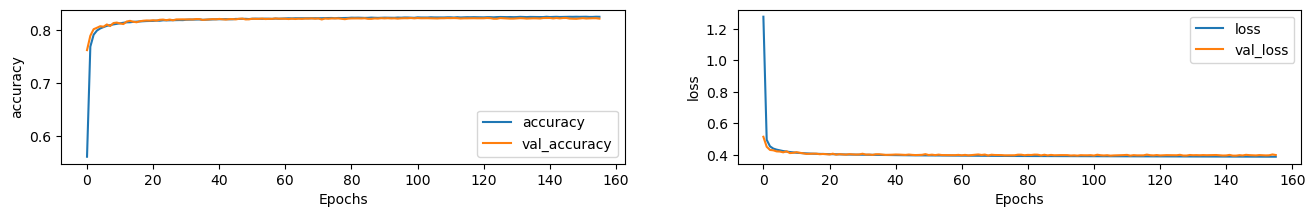

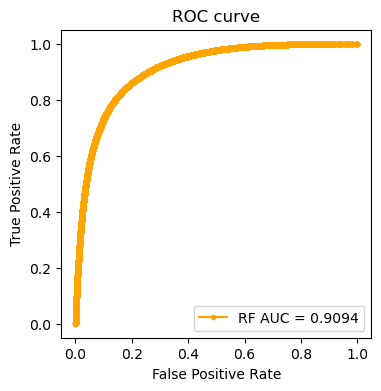

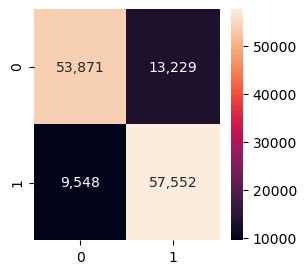

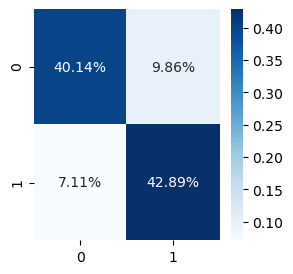

In [16]:
test_loss, test_acc = model_high.evaluate([pep_test, aa_test
#                                            , en_test, ec_test, e1_test, e2_test
                                          ], y_test)
print('Test Loss: {}'.format(test_loss))
print('Test Accuracy: {}'.format(test_acc))

# prediction
y_pred = [1 if i>=0.5 else 0 for i in model_high.predict([pep_test, aa_test
#                                                           , en_test, ec_test, e1_test, e2_test
                                                         ])]
print(classification_report(y_test, y_pred))
# AUC
probs = model_high.predict([pep_test, aa_test
#                             , en_test, ec_test, e1_test, e2_test
                           ])
rf_auc = roc_auc_score(y_test, probs)
print('rf auc : {}'.format(rf_auc))
# plot the roc curve for the model_high
rf_fpr, rf_tpr, _ = roc_curve(y_test, probs)
plt.figure(figsize=(4, 4))
plt.plot(rf_fpr, rf_tpr, marker='.', label='RF AUC = {:.4f}'.format(rf_auc), color='orange')
plt.title('ROC curve')
# axis labels
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
# show the legend
plt.legend()
# show the plot
plt.show()

cf_matrix = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(3, 3))
sns.heatmap(cf_matrix, annot=True, fmt=',.0f')
plt.show()
plt.figure(figsize=(3, 3))
sns.heatmap(cf_matrix/np.sum(cf_matrix), annot=True, 
            fmt='.2%', cmap='Blues')
plt.show()

In [ ]:
# # Calling `save('my_model.h5')` creates a h5 file `my_model.h5`.
# model_high.save("compareModel/2021KSBi_multi_lr0005")